Partie 1 : Manipulation des RDD

In [ ]:
# %% [Installation et importations]
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from google.colab import drive
import os
import shutil
import statistics

# %% [Initialisation de Spark]
try:
    sc.stop()
except:
    pass

conf = SparkConf().setAppName("WaterAnalysis").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)


# %% [1. Charger le fichier CSV en RDD et supprimer l’en-tête]
file_path = "cleaned_global_water_consumption.csv"
raw_rdd = sc.textFile(file_path)
print(f"\nNombre initial de lignes : {raw_rdd.count()}")

header = raw_rdd.first()
data_rdd = raw_rdd.filter(lambda line: line != header)
print(f"Lignes après suppression de l'en-tête : {data_rdd.count()}")

# %% [2. Transformer les données (split et conversion)]
def parse_line(line):
    parts = line.split(",")
    if len(parts) != 9:
        return None
    try:
        return (
            parts[0].strip(),        # Country
            int(parts[1]),           # Year
            float(parts[2]),         # Total Consumption
            float(parts[3]),         # Per Capita
            float(parts[4]),         # Agricultural %
            float(parts[5]),         # Industrial %
            float(parts[6]),         # Household %
            float(parts[7]),         # Rainfall
            float(parts[8])          # Groundwater Depletion
        )
    except ValueError:
        return None

parsed_rdd = data_rdd.map(parse_line).filter(lambda x: x is not None)
print(f"\nLignes valides après parsing : {parsed_rdd.count()}")
print("\nExemples de données après parsing :")
for row in parsed_rdd.take(5):
    print(row)

# %% [3. Application des transformations de base]

# a) map : structurer (Country, Total Consumption)
mapped_rdd = parsed_rdd.map(lambda x: (x[0], x[2]))
print("\nExemples après map (pays, consommation totale) :")
for row in mapped_rdd.take(5):
    print(row)

# b) filter : garder seulement consommation totale > 0
filtered_rdd = mapped_rdd.filter(lambda x: x[1] > 0)
print(f"\nNombre de lignes après filtre (consommation > 0) : {filtered_rdd.count()}")
print("\nExemples après filtre :")
for row in filtered_rdd.take(5):
    print(row)

# c) reduce : Consommation totale par pays
reduced_rdd = filtered_rdd.reduceByKey(lambda a, b: a + b)
print("\nExemples après reduceByKey (consommation totale par pays) :")
for row in reduced_rdd.take(5):
    print(row)

# d) sortByKey : Tri alphabétique des pays
sorted_rdd = reduced_rdd.sortByKey()
print("\nExemples après sortByKey (tri alphabétique) :")
for row in sorted_rdd.take(5):
    print(row)

# %% [EXPLORATIONS SUPPLÉMENTAIRES]

# e) Trier par consommation décroissante (TOP pays consommateurs)
sorted_by_value = reduced_rdd.sortBy(lambda x: -x[1])
print("\nTop 10 des pays consommateurs d'eau :")
for i, (country, total) in enumerate(sorted_by_value.take(10), 1):
    print(f"{i}. {country:<20} : {total:.2f} milliards m³")

# f) Trouver pays avec MIN et MAX consommation
min_country = reduced_rdd.min(key=lambda x: x[1])
max_country = reduced_rdd.max(key=lambda x: x[1])

print(f"\nPays avec la consommation la plus FAIBLE : {min_country[0]} ({min_country[1]:.2f} milliards m³)")
print(f"Pays avec la consommation la plus ÉLEVÉE : {max_country[0]} ({max_country[1]:.2f} milliards m³)")

# g) Calculer moyenne de consommation entre pays
consumption_values = reduced_rdd.map(lambda x: x[1]).collect()
average_consumption = statistics.mean(consumption_values)
print(f"\nConsommation moyenne d'eau par pays : {average_consumption:.2f} milliards m³")

# h) Nombre total de pays étudiés
total_countries = reduced_rdd.count()
print(f"\nNombre total de pays dans les données : {total_countries}")

# i) Rechercher pays spécifiques (exemple : France, USA, India)
specific_countries = ["France", "United States", "India"]
for country in specific_countries:
    search = reduced_rdd.filter(lambda x: x[0] == country).collect()
    if search:
        print(f"{country} : {search[0][1]:.2f} milliards m³")
    else:
        print(f"{country} : Données non trouvées.")

# %% [Sauvegarde du résultat]
output_rdd_path = "/content/drive/MyDrive/Colab Notebooks/rdd_final_results"
if os.path.exists(output_rdd_path):
    shutil.rmtree(output_rdd_path)

sorted_rdd.saveAsTextFile(output_rdd_path)
print(f"\nRésultats finaux sauvegardés dans : {output_rdd_path}")



Nombre initial de lignes : 501
Lignes après suppression de l'en-tête : 500

Lignes valides après parsing : 500

Exemples de données après parsing :
('Argentina', 2000, 481.49, 235.4314286, 48.55, 20.84428571, 30.1, 1288.698571, 3.255714286)
('Argentina', 2001, 455.063, 299.551, 48.465, 26.943, 22.55, 1371.729, 3.12)
('Argentina', 2002, 482.7492308, 340.1246154, 50.37538462, 29.04230769, 23.34923077, 1590.305385, 2.733846154)
('Argentina', 2003, 452.66, 326.7566667, 49.08666667, 30.476, 24.44, 1816.012667, 2.708)
('Argentina', 2004, 634.566, 230.346, 38.67, 36.67, 23.924, 815.998, 1.902)

Exemples après map (pays, consommation totale) :
('Argentina', 481.49)
('Argentina', 455.063)
('Argentina', 482.7492308)
('Argentina', 452.66)
('Argentina', 634.566)

Nombre de lignes après filtre (consommation > 0) : 500

Exemples après filtre :
('Argentina', 481.49)
('Argentina', 455.063)
('Argentina', 482.7492308)
('Argentina', 452.66)
('Argentina', 634.566)

Exemples après reduceByKey (consommatio

Partie 2 : Utilisation de Spark SQL

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

# Recharger et parser les données correctement en DataFrame
schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("TotalConsumption", FloatType(), True),
    StructField("PerCapita", FloatType(), True),
    StructField("AgriculturalPercent", FloatType(), True),
    StructField("IndustrialPercent", FloatType(), True),
    StructField("HouseholdPercent", FloatType(), True),
    StructField("Rainfall", FloatType(), True),
    StructField("GroundwaterDepletion", FloatType(), True)
])

# Parser l'ancien RDD parsed_rdd en DataFrame
df = spark.createDataFrame(parsed_rdd, schema=schema)

# Vérification des données manquantes
df = df.dropna()

# Afficher un aperçu des données
df.show(5)

# Créer une vue temporaire pour utiliser SQL
df.createOrReplaceTempView("water_consumption")

# --------------------------------------
# 1. Classer les pays selon la proportion d'utilisation de l’eau en agriculture
query_agriculture = """
SELECT Country, AVG(AgriculturalPercent) as AvgAgricultureUse
FROM water_consumption
GROUP BY Country
ORDER BY AvgAgricultureUse DESC
"""
result_agriculture = spark.sql(query_agriculture)
print("\nPays classés par utilisation de l'eau en agriculture :")
result_agriculture.show(10)

# --------------------------------------
# 2. Identifier les pays avec l’utilisation industrielle de l’eau la plus élevée
query_industry = """
SELECT Country, AVG(IndustrialPercent) as AvgIndustrialUse
FROM water_consumption
GROUP BY Country
ORDER BY AvgIndustrialUse DESC
"""
result_industry = spark.sql(query_industry)
print("\nPays classés par utilisation de l'eau dans l'industrie :")
result_industry.show(10)

# --------------------------------------
# 3. Analyser la corrélation entre épuisement des eaux souterraines et consommation totale
query_correlation = """
SELECT GroundwaterDepletion, TotalConsumption
FROM water_consumption
WHERE GroundwaterDepletion IS NOT NULL AND TotalConsumption IS NOT NULL
"""
result_correlation = spark.sql(query_correlation)
print("\nRelation entre Groundwater Depletion et Total Consumption :")
result_correlation.show(5)

# Calcul de la corrélation en utilisant Pearson
correlation_data = result_correlation.rdd.map(lambda row: (row['GroundwaterDepletion'], row['TotalConsumption'])).collect()
if correlation_data:
    from scipy.stats import pearsonr
    x, y = zip(*correlation_data)
    correlation, p_value = pearsonr(x, y)
    print(f"\nCoefficient de corrélation (Pearson) : {correlation:.3f}")
else:
    print("\nPas assez de données pour calculer la corrélation.")

# --------------------------------------
# 4. Comparer la consommation domestique entre les continents
# Continent mapping
# Full Continent mapping
continent_mapping = {
    "Canada": "North America",
    "China": "Asia",
    "France": "Europe",
    "Germany": "Europe",
    "India": "Asia",
    "Indonesia": "Asia",
    "Italy": "Europe",
    "Japan": "Asia",
    "Mexico": "North America",
    "Saudi Arabia": "Asia",
    "South Africa": "Africa",
    "South Korea": "Asia",
    "Spain": "Europe",
    "UK": "Europe",
    "United States": "North America"
}

# Créer une fonction UDF pour attribuer un continent
def get_continent(country):
    return continent_mapping.get(country, "Other")

# Enregistrer la fonction UDF dans Spark
spark.udf.register("getContinent", get_continent, StringType())

# Ajouter une colonne "Continent" à partir de la fonction UDF
df_with_continent = df.withColumn("Continent", F.expr("getContinent(Country)"))
df_with_continent.createOrReplaceTempView("water_consumption_continent")

# Consommation domestique moyenne par continent
query_domestic = """
SELECT Continent, AVG(HouseholdPercent) as AvgHouseholdUse
FROM water_consumption_continent
GROUP BY Continent
ORDER BY AvgHouseholdUse DESC
"""
result_domestic = spark.sql(query_domestic)
print("\nConsommation domestique moyenne par continent :")
result_domestic.show()


# --------------------------------------
# 5. Étudier l’évolution de l’impact des précipitations sur la consommation d’eau au fil des années
query_rainfall = """
SELECT Year, AVG(Rainfall) as AvgRainfall
FROM water_consumption
GROUP BY Year
ORDER BY Year
"""
result_rainfall = spark.sql(query_rainfall)
print("\nÉvolution moyenne des précipitations par année :")
result_rainfall.show()



+---------+----+----------------+---------+-------------------+-----------------+----------------+---------+--------------------+
|  Country|Year|TotalConsumption|PerCapita|AgriculturalPercent|IndustrialPercent|HouseholdPercent| Rainfall|GroundwaterDepletion|
+---------+----+----------------+---------+-------------------+-----------------+----------------+---------+--------------------+
|Argentina|2000|          481.49|235.43143|              48.55|        20.844286|            30.1|1288.6986|           3.2557142|
|Argentina|2001|         455.063|  299.551|             48.465|           26.943|           22.55| 1371.729|                3.12|
|Argentina|2002|       482.74924| 340.1246|          50.375385|        29.042307|       23.349232|1590.3054|           2.7338462|
|Argentina|2003|          452.66|326.75665|          49.086666|           30.476|           24.44|1816.0127|               2.708|
|Argentina|2004|         634.566|  230.346|              38.67|            36.67|         

Partie 3 : Visualisation des Résultats

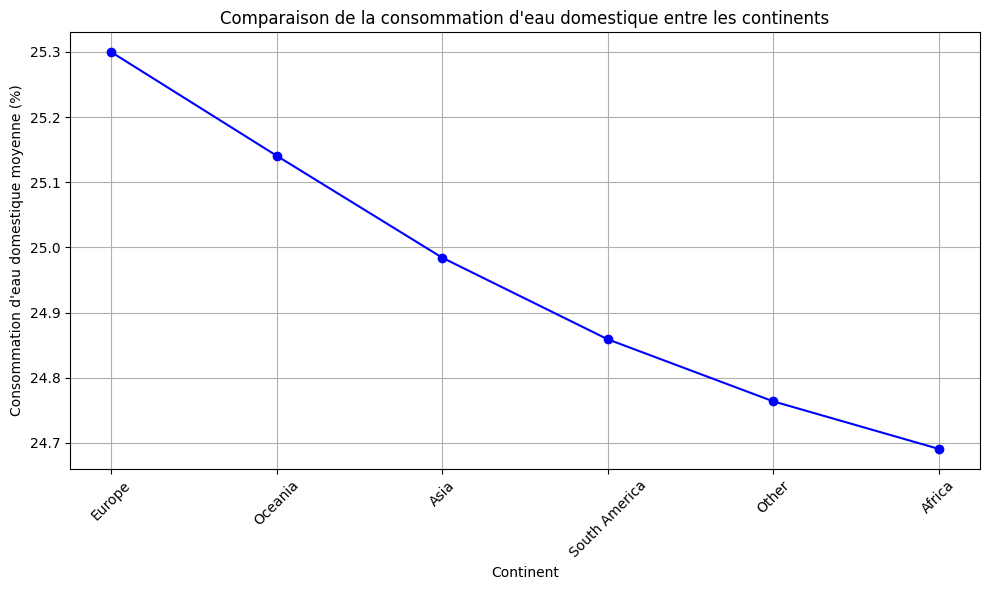

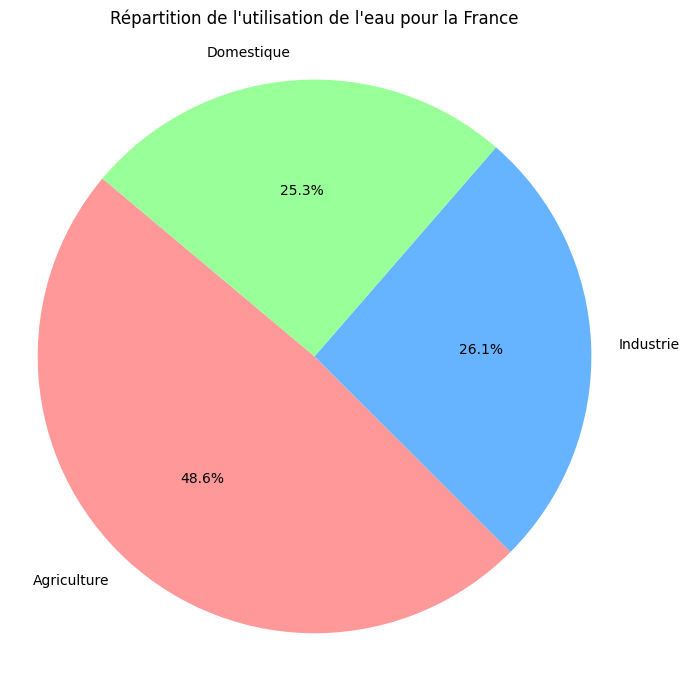

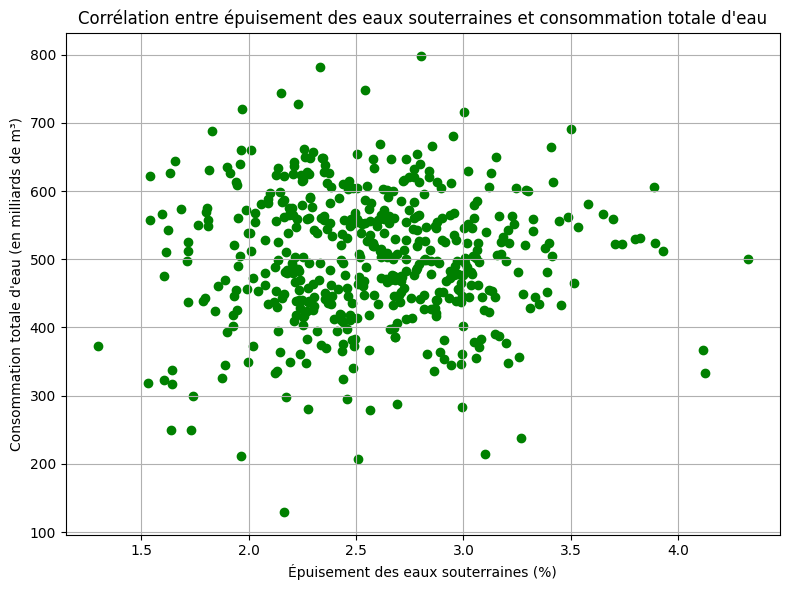

In [ ]:
# %% Convertir les résultats des requêtes SQL en DataFrame Pandas

# 1. Consommation domestique moyenne par continent (query_domestic)
result_domestic_pandas = result_domestic.toPandas()

# 2. Répartition de l’utilisation de l’eau pour un pays donné
# Exemple avec le pays "France" (tu peux modifier ce pays)
query_water_distribution = """
SELECT Country, AVG(AgriculturalPercent) as AvgAgricultureUse,
       AVG(IndustrialPercent) as AvgIndustrialUse,
       AVG(HouseholdPercent) as AvgHouseholdUse
FROM water_consumption
WHERE Country = 'France'
GROUP BY Country
"""
result_distribution_pandas = spark.sql(query_water_distribution).toPandas()

# 3. Relation entre épuisement des eaux souterraines et consommation totale (query_correlation)
result_correlation_pandas = result_correlation.toPandas()

import matplotlib.pyplot as plt

# Graphique en ligne comparant la consommation d'eau domestique entre les continents
plt.figure(figsize=(10, 6))
plt.plot(result_domestic_pandas['Continent'], result_domestic_pandas['AvgHouseholdUse'], marker='o', linestyle='-', color='b')
plt.title('Comparaison de la consommation d\'eau domestique entre les continents')
plt.xlabel('Continent')
plt.ylabel('Consommation d\'eau domestique moyenne (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Diagramme en secteurs pour la répartition de l'utilisation de l'eau pour la France
labels = ['Agriculture', 'Industrie', 'Domestique']
sizes = [
    result_distribution_pandas['AvgAgricultureUse'][0],
    result_distribution_pandas['AvgIndustrialUse'][0],
    result_distribution_pandas['AvgHouseholdUse'][0]
]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Répartition de l\'utilisation de l\'eau pour la France')
plt.axis('equal')  # Pour rendre le cercle égal
plt.tight_layout()
plt.show()

# Corrélation entre l'épuisement des eaux souterraines et la consommation totale d'eau
plt.figure(figsize=(8, 6))
plt.scatter(result_correlation_pandas['GroundwaterDepletion'], result_correlation_pandas['TotalConsumption'], color='g')
plt.title('Corrélation entre épuisement des eaux souterraines et consommation totale d\'eau')
plt.xlabel('Épuisement des eaux souterraines (%)')
plt.ylabel('Consommation totale d\'eau (en milliards de m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


Partie 4 : Analyse des résultats

1. Quels pays utilisent majoritairement leur eau pour l’agriculture ?

D'après les résultats des pays classés par utilisation de l'eau en agriculture, les pays qui utilisent le plus d'eau pour l'agriculture sont :

Australie (52.80%)

Turquie (51.84%)

Chine (51.71%)

Argentine (51.44%)

Afrique du Sud (50.67%)

Ces pays utilisent majoritairement leur eau pour l'agriculture en raison de leurs besoins en irrigation, notamment dans des régions arides ou semi-arides.


2. Quels sont les impacts de l’utilisation industrielle de l’eau sur la consommation totale ?

La requête Pays classés par utilisation de l'eau dans l'industrie montre que certains pays ont une forte proportion d'eau utilisée pour l'industrie :

Canada (29.47%)

Turquie (29.10%)

Japon (28.82%)

Australie (28.72%)

Afrique du Sud (28.69%)

Cependant, la corrélation entre l'épuisement des eaux souterraines et la consommation totale d'eau est très faible (coefficient de corrélation de 0.020), ce qui suggère qu'il n'y a pas de relation directe forte entre l'utilisation industrielle de l'eau et la consommation totale d'eau.

Cela signifie que l'utilisation industrielle de l'eau ne semble pas avoir un impact majeur sur la consommation totale d'eau par rapport à d'autres secteurs comme l'agriculture ou les usages domestiques.

3. Peut-on établir une relation entre l’épuisement des eaux souterraines et la consommation totale ?

La corrélation entre l'épuisement des eaux souterraines (GroundwaterDepletion) et la consommation totale d'eau (TotalConsumption) est très faible avec un coefficient de 0.020, ce qui indique qu'il n'y a pas de lien linéaire significatif entre ces deux variables. Ainsi, on peut conclure qu'il n'existe pas de relation forte entre l'épuisement des eaux souterraines et la consommation totale d'eau.

4. Existe-t-il une différence significative dans la consommation domestique entre continents ?

D'après les résultats de la consommation domestique par continent, les moyennes sont les suivantes :

Europe : 25.30%

Océanie : 25.14%

Asie : 24.98%

Amérique du Sud : 24.86%

Autres : 24.76%

Afrique : 24.69%

Les différences entre les continents sont relativement faibles, bien que l'Europe ait une consommation domestique légèrement plus élevée. Cela peut être dû à des différences de niveau de vie et de gestion des ressources en eau, mais aucune différence marquante n'est observée entre les continents.

5. Comment l’impact des précipitations évolue-t-il dans le temps ?

L'évolution des précipitations au fil des années montre quelques variations, mais aucune tendance extrêmement nette. Les moyennes annuelles de précipitations oscillent autour de 1500 mm, avec des pics (par exemple en 2002 avec 1674 mm) et des baisses (par exemple en 2009 avec 1354 mm). Il n'y a pas de tendance évidente à la hausse ou à la baisse sur la période observée, bien que certains pics et creux puissent être observés au fil des années. Cela pourrait refléter des phénomènes climatiques naturels ou des variations annuelles normales, mais aucune tendance stable n'est évidente.

Conclusion :
Utilisation agricole de l'eau : L'agriculture reste le secteur principal pour l'utilisation de l'eau dans des pays comme l'Australie, la Turquie et la Chine.

Utilisation industrielle : L'impact de l'industrie sur la consommation totale semble moins marqué, avec une faible corrélation avec l'épuisement des eaux souterraines.

Consommation domestique : Les différences entre continents en matière de consommation domestique d'eau sont faibles, mais l'Europe montre légèrement plus de consommation.

Précipitations : L'impact des précipitations n'évolue pas de manière évidente dans le temps, avec des fluctuations annuelles.